In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

In [2]:
data_dict = {"IP": "INDPRO"}
freq = "M"
start = datetime.datetime(1919, 1, 1)
end = datetime.datetime(2022, 11, 30)
# end =datetime.datetime.today()
data = {}
data = gather_data(data_dict, start, 
          end = end, freq = freq)
data["IP"] = data["IP"].div(100)
data_dict = {"Data":data}
data_dict["Log"] = np.log(data)
data_dict["Log"]

,IP
DATE,
1919-01-31,-3.022795
1919-02-28,-3.068002
1919-03-31,-3.097322
1919-04-30,-3.079636
1919-05-31,-3.073802
...,...
2022-07-31,0.030847
2022-08-31,0.031832
2022-09-30,0.034675


<AxesSubplot:xlabel='DATE'>

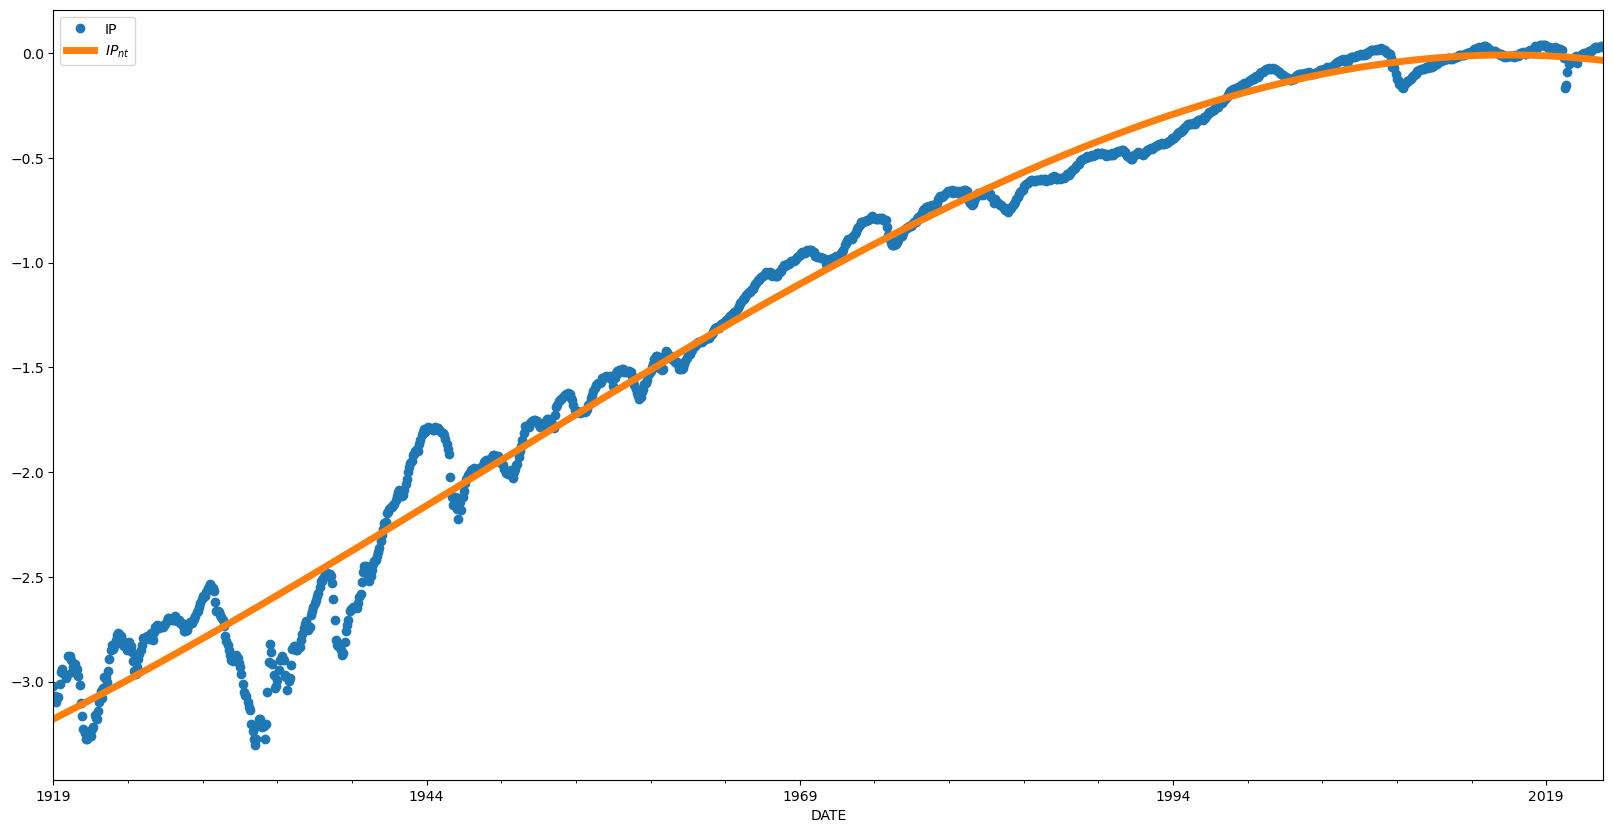

In [3]:
X_vars = ["constant", "t"]
reg_data = data_dict["Log"]
reg_data["t"] = np.arange(len(reg_data.index))
real_var = "IP"
# add polynomial terms
for i in range(2,3 + 1):
    polynomial_time = "$t^" +str(i) + "$"        
    reg_data[polynomial_time] = np.arange(len(reg_data.index)) ** i
    X_vars.append(polynomial_time)
reg_data["constant"] = 1
reg_data.dropna(inplace=True)
y = reg_data[real_var]
X = reg_data[X_vars]
reg = sm.OLS(y,X)
results = reg.fit()
# estimate long-run trend
reg_data["$" + real_var + "_{nt}$"] = results.predict(reg_data[X_vars])
# = results.fittedvalues
fig, ax = plt.subplots(figsize = (20,10))
reg_data[[real_var]].plot.line(ls = "", marker = "o", linewidth = 5, ax = ax)
reg_data[["$" + real_var + "_{nt}$"]].plot.line(linewidth = 5, ax = ax)

In [4]:
reg_data["$" + real_var + "_{ct}$"] = reg_data[real_var].sub(reg_data["$" + real_var + "_{nt}$"]).values
reg_data

,IP,t,$t^2$,$t^3$,constant,$IP_{nt}$,$IP_{ct}$
DATE,,,,,,,
1919-01-31,-3.022795,0,0,0,1,-3.178475,0.155679
1919-02-28,-3.068002,1,1,1,1,-3.175457,0.107455
1919-03-31,-3.097322,2,4,8,1,-3.172436,0.075114
1919-04-30,-3.079636,3,9,27,1,-3.169411,0.089775
1919-05-31,-3.073802,4,16,64,1,-3.166382,0.092580
...,...,...,...,...,...,...,...
2022-07-31,0.030847,1242,1542564,1915864488,1,-0.032224,0.063071
2022-08-31,0.031832,1243,1545049,1920495907,1,-0.032893,0.064725
2022-09-30,0.034675,1244,1547536,1925134784,1,-0.033572,0.068246


Text(0.5, 1.0, '$IP_{c}$')

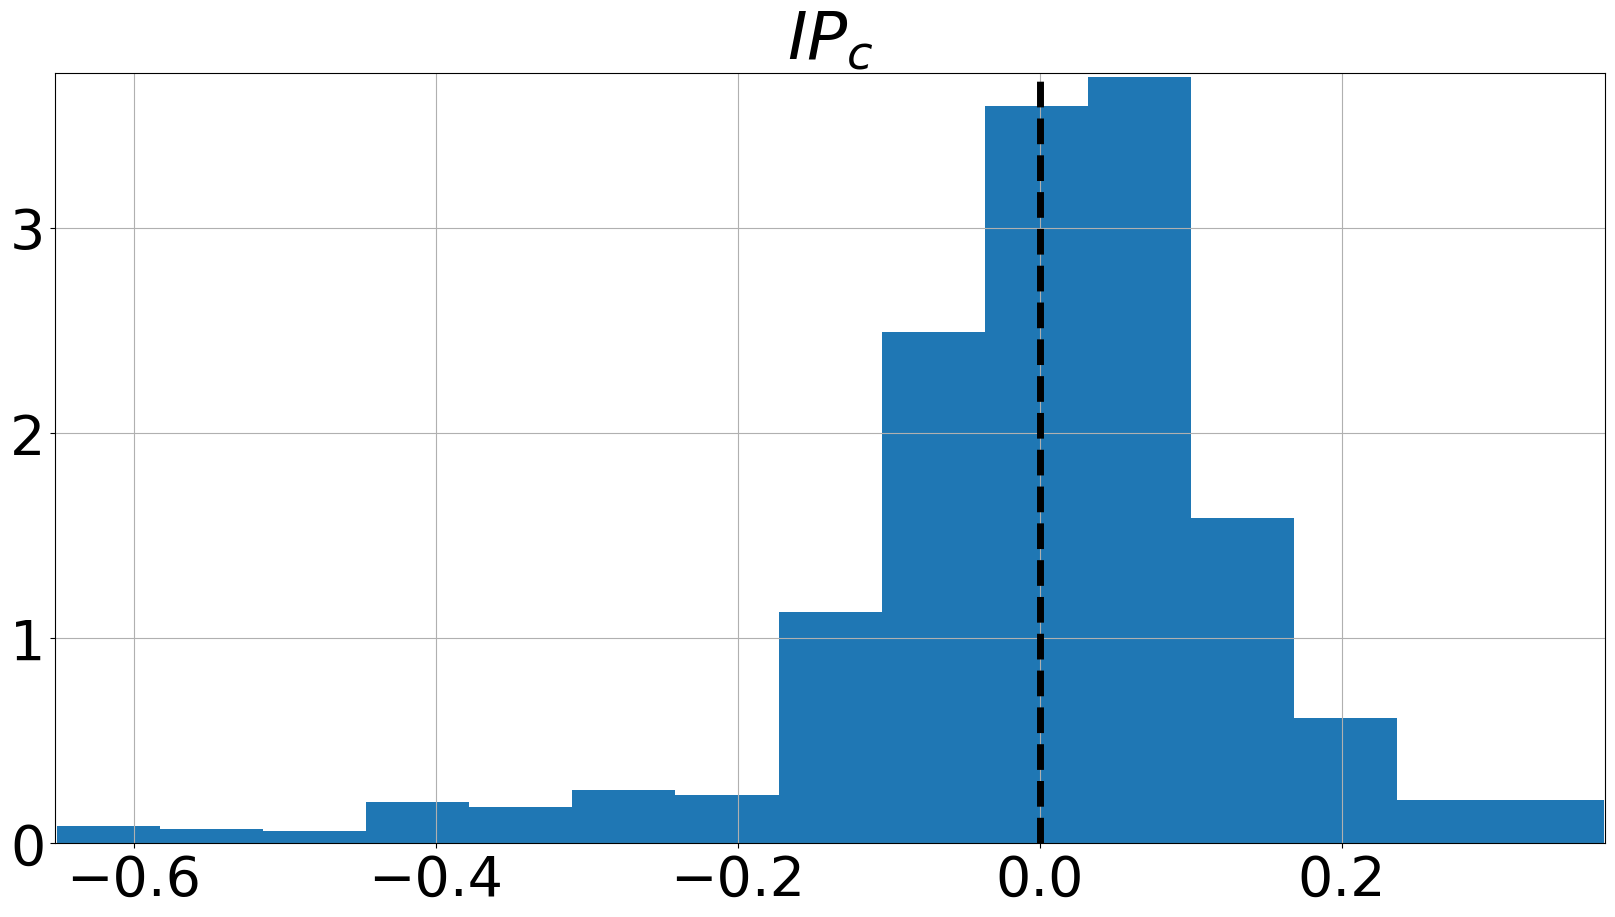

In [5]:
plt.rcParams['axes.xmargin'] = .001
plt.rcParams['axes.ymargin'] = .005
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(figsize = (20,10))
reg_data["$IP_{ct}$"].hist(density = True, bins = 15)
ax.axvline(reg_data["$IP_{ct}$"].mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$IP_{c}$")

Text(0, 0.5, 'Distance from Trend as Proportion of ${IP_c}$')

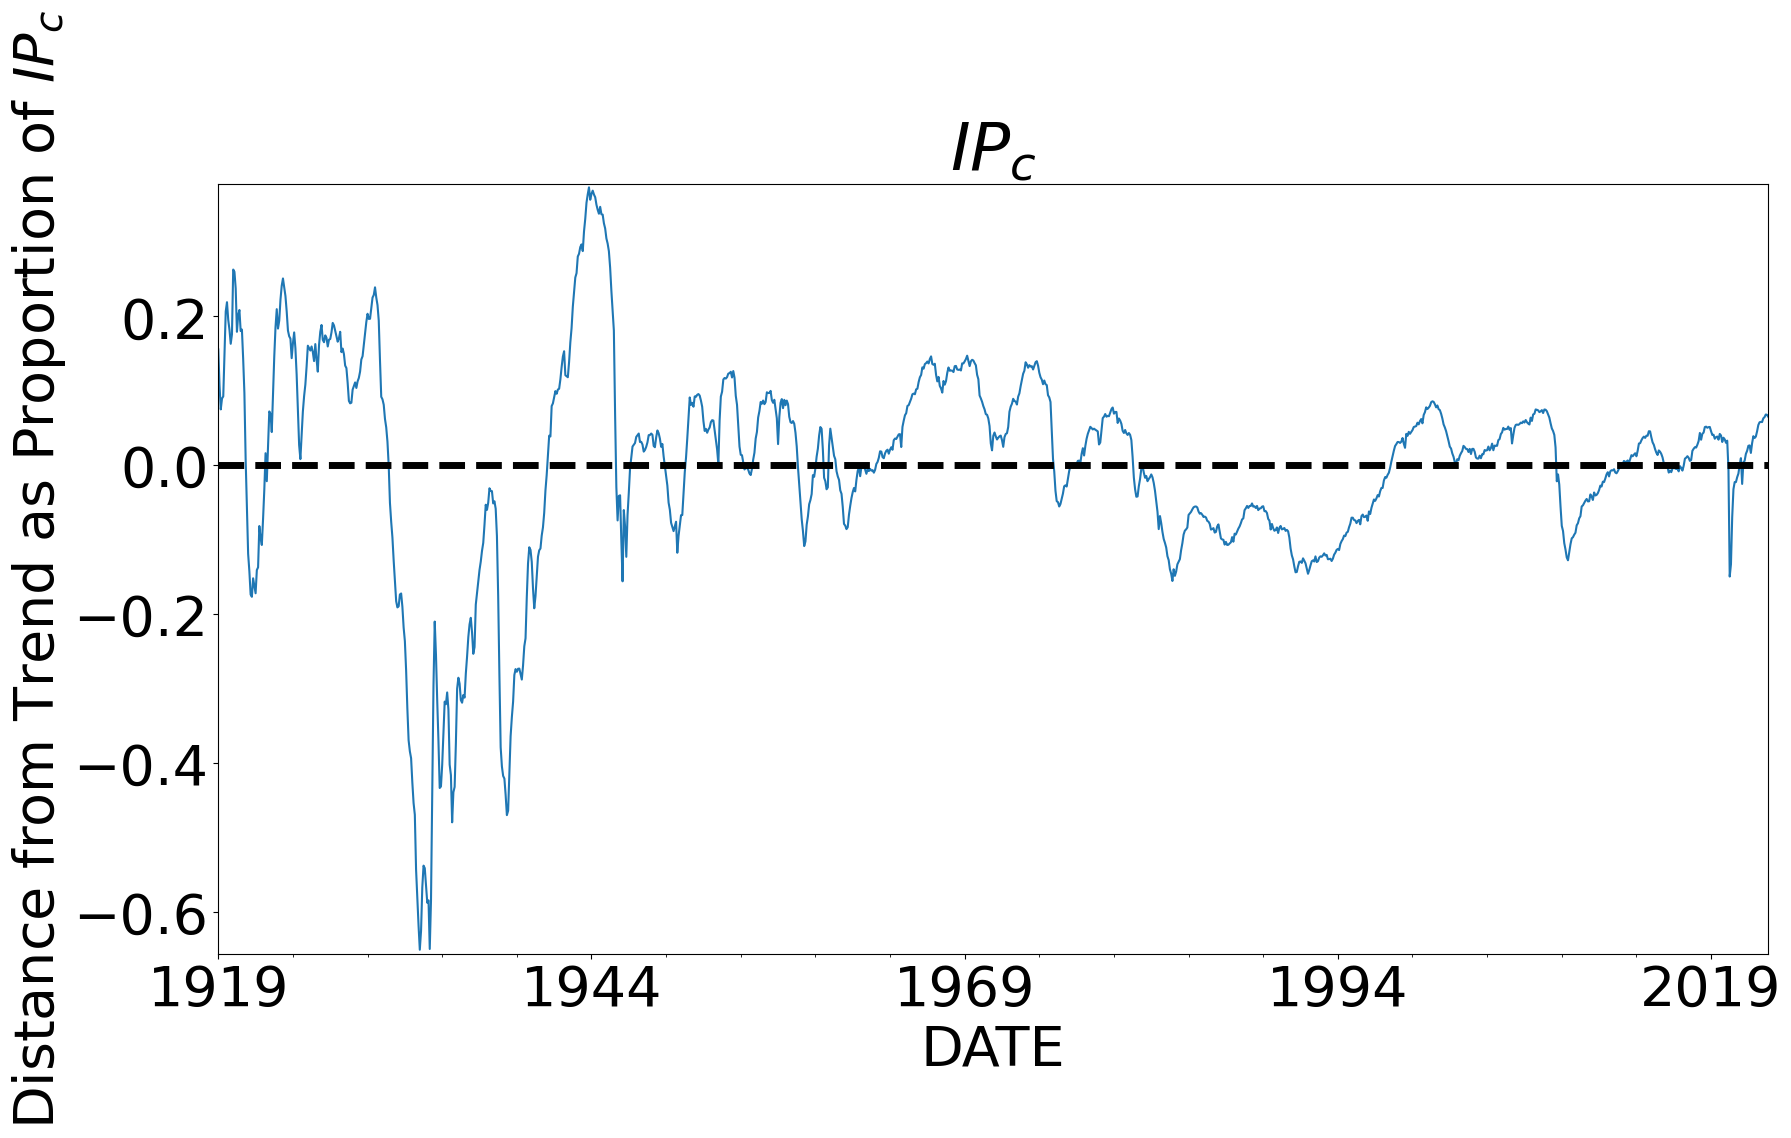

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
reg_data["$IP_{ct}$"].plot.line()
ax.axhline(reg_data["$IP_{ct}$"].mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$IP_{c}$")
ax.set_ylabel("Distance from Trend as Proportion of ${IP_c}$")

Text(0, 0.5, '$\\sigma_{IP_c}$')

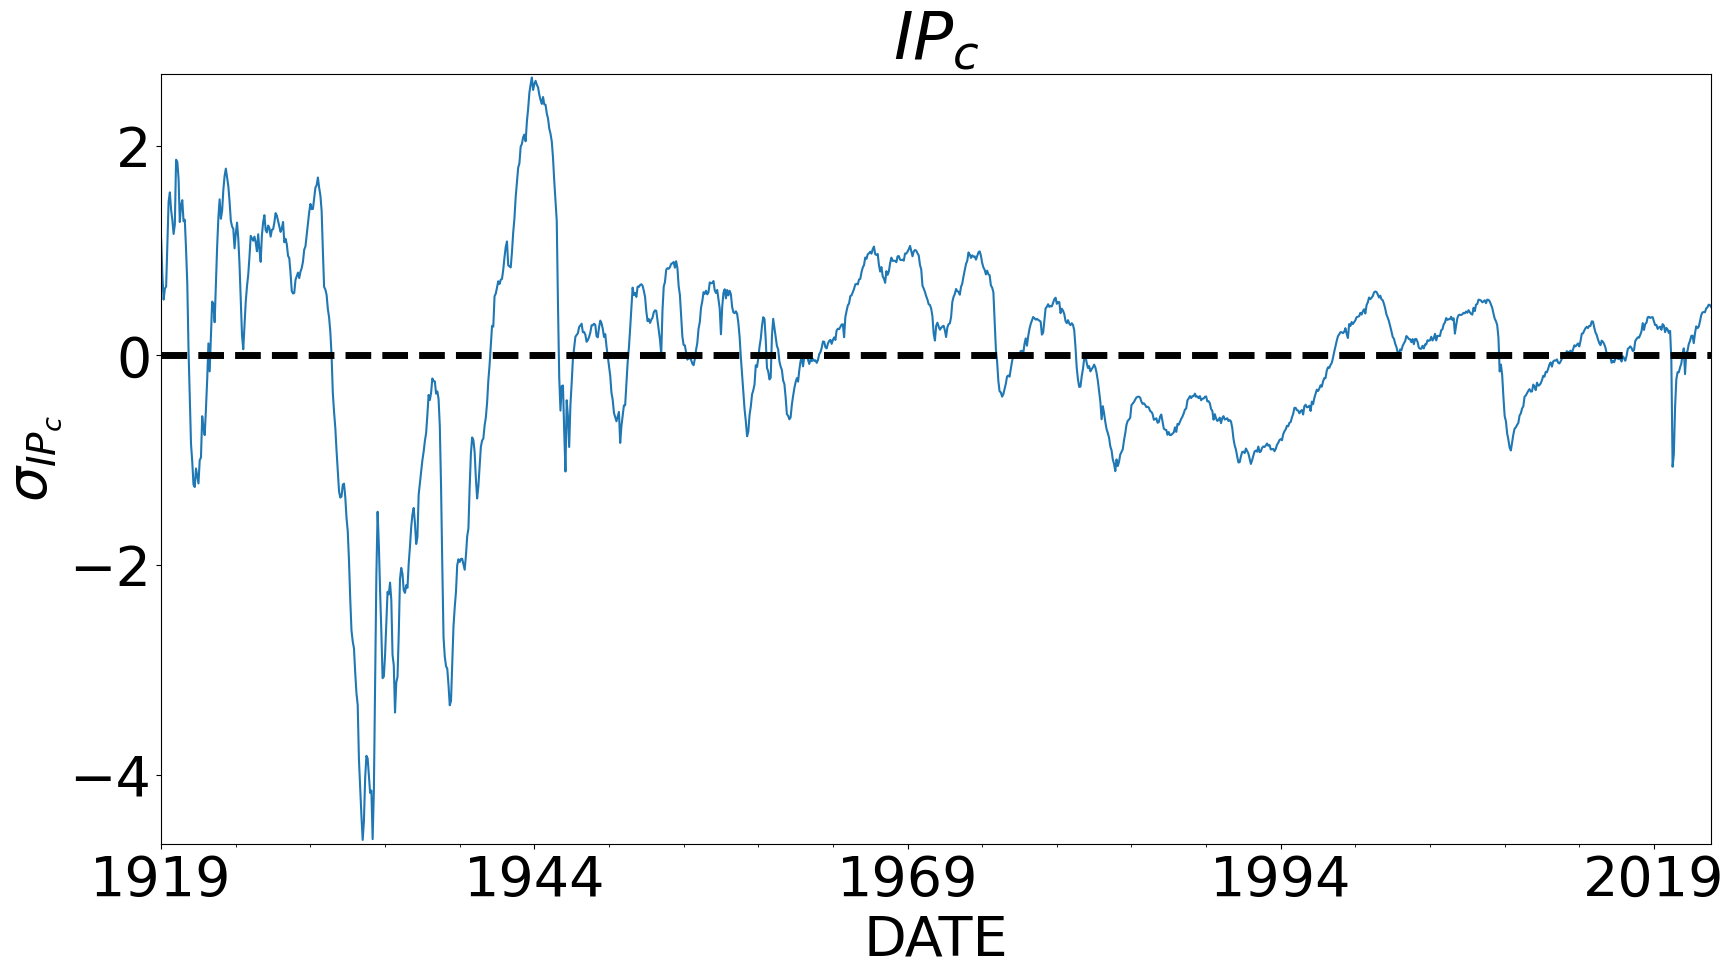

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
reg_sd_data = reg_data["$IP_{ct}$"].div(reg_data["$IP_{ct}$"].std())
reg_sd_data.plot.line()
ax.axhline(reg_sd_data.mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$IP_c$")
ax.set_ylabel("$\\sigma_{IP_c}$")

Text(0.5, 0, 'Lag')

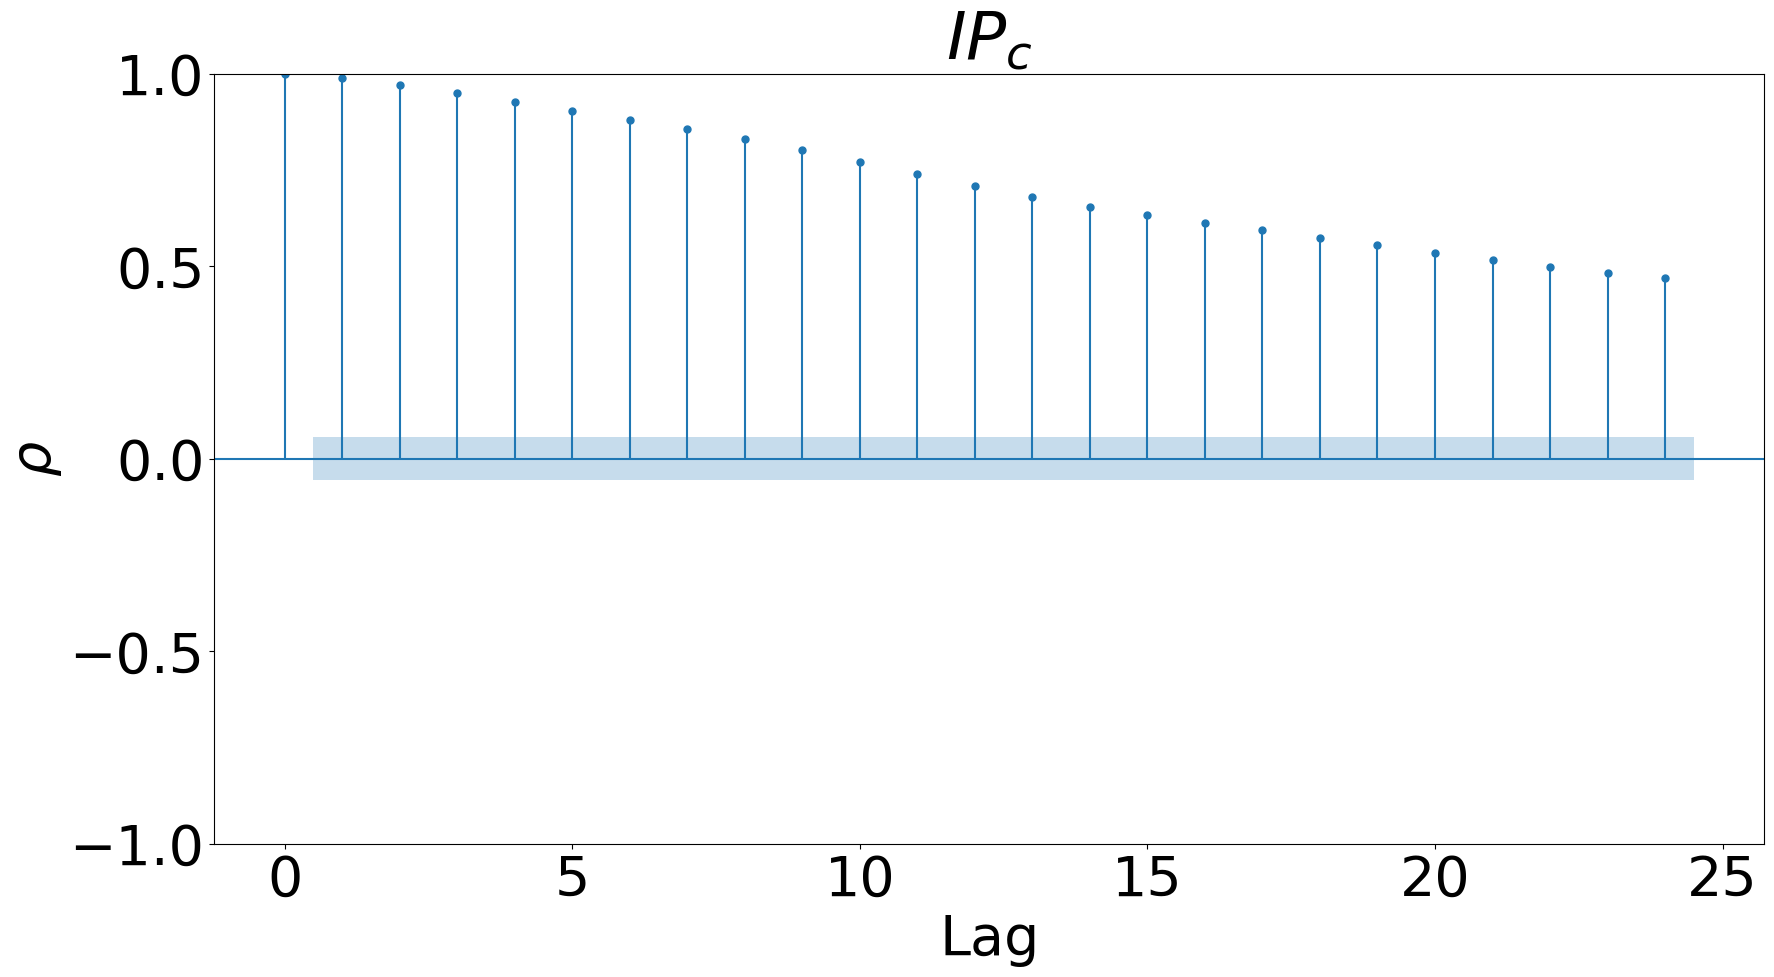

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize = (20,10))
plot_acf( reg_data["$IP_{ct}$"], title = "$IP_{c}$", ax = ax, lags = 24, bartlett_confint = False)
ax.set_ylabel("$\\rho$")
ax.set_xlabel("Lag")


Text(0.5, 1.0, '$IP_{c}$')

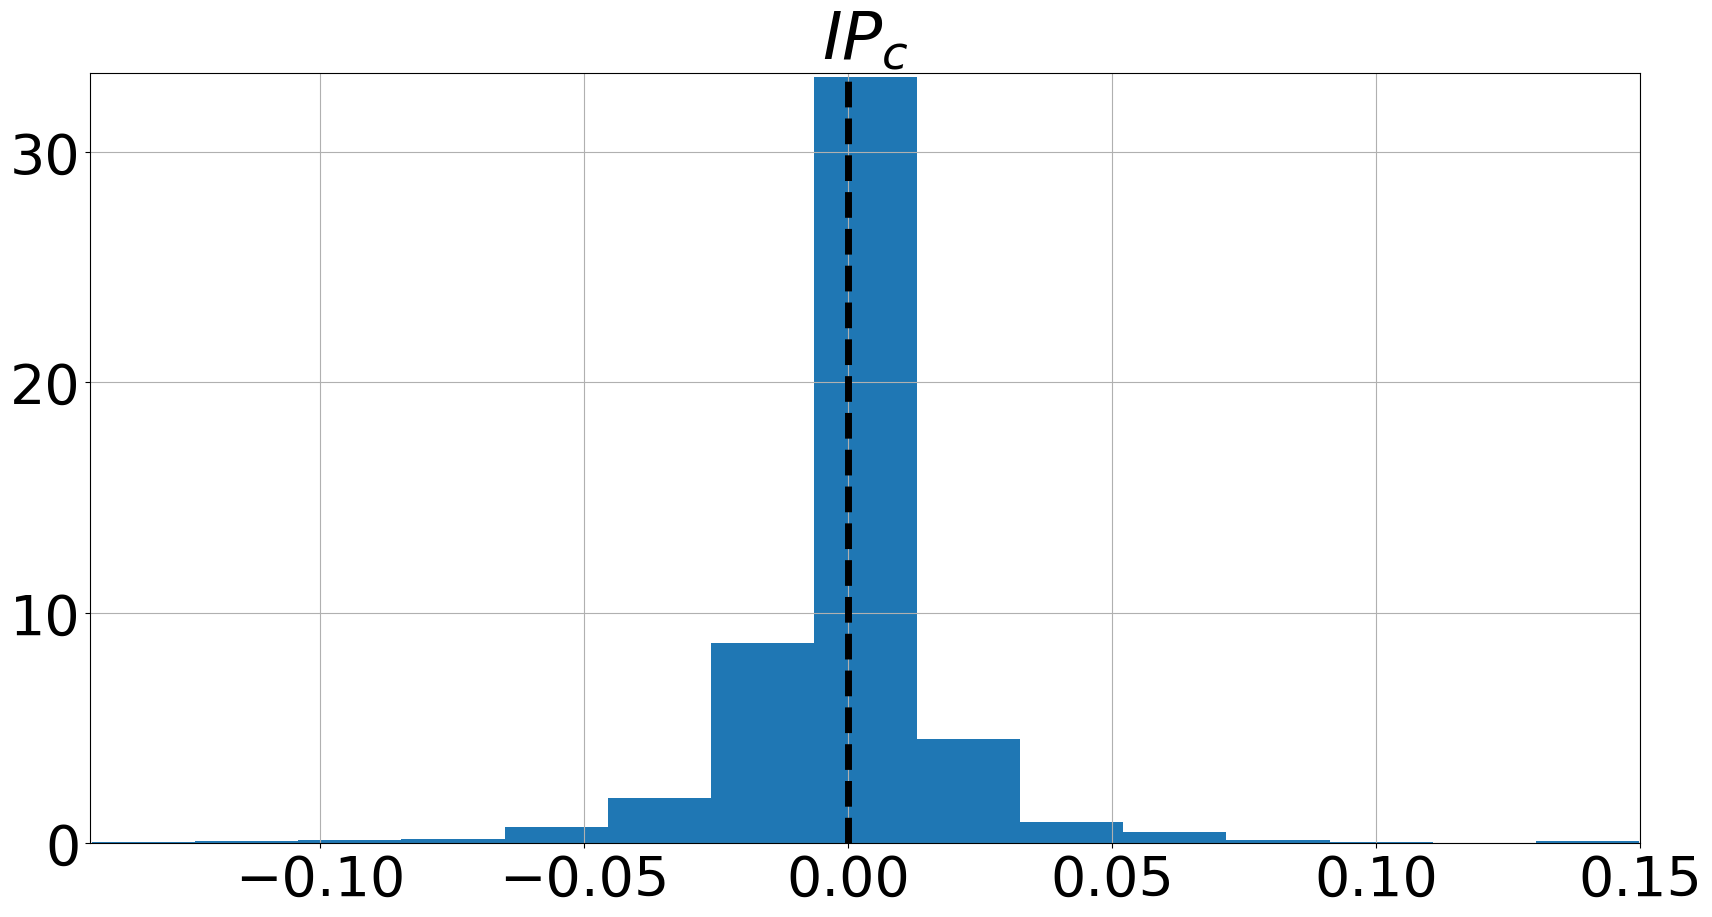

In [9]:
fig, ax = plt.subplots(figsize = (20,10))
reg_diff_data = reg_data.diff()["$IP_{ct}$"]
reg_diff_data.hist(density = True, bins = 15)
ax.axvline(reg_diff_data.mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$IP_{c}$")

Text(0.5, 1.0, '$\\Delta IP_{c}$')

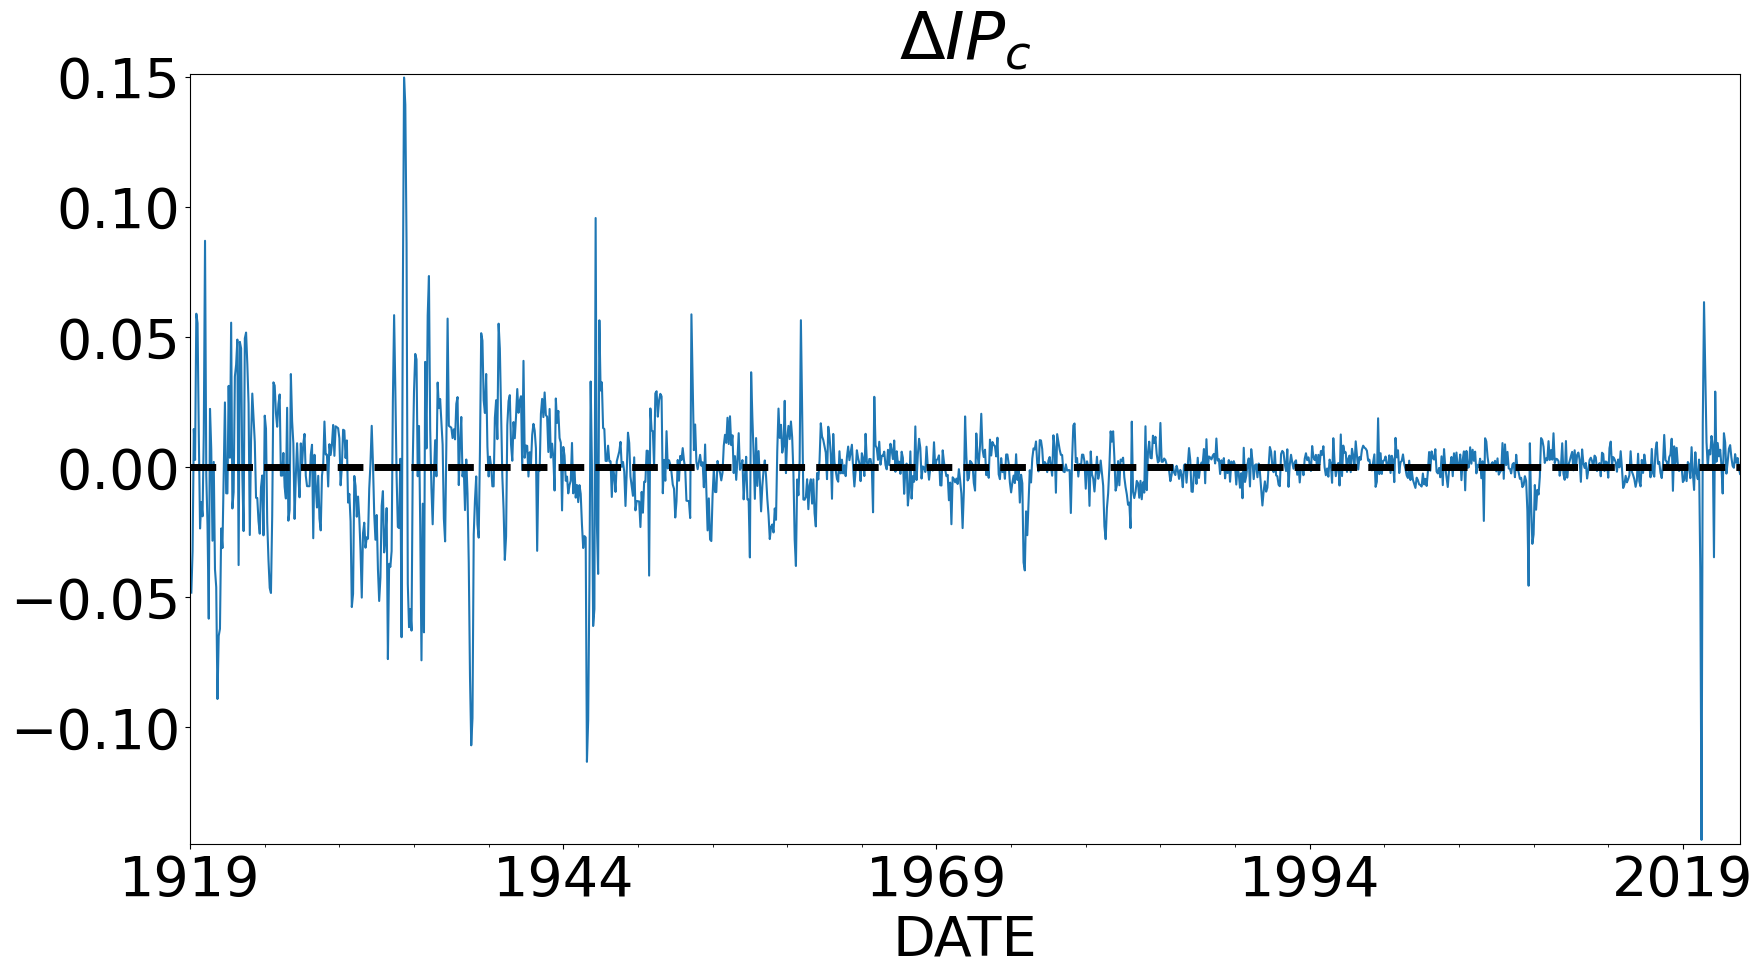

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
reg_diff_data.plot.line()
ax.axhline(reg_diff_data.mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$\\Delta IP_{c}$")

count    1246.000000
mean       -0.003766
std         1.000000
min        -7.429232
25%        -0.291093
50%         0.039843
75%         0.323624
max         7.765495
Name: $IP_{ct}$, dtype: float64

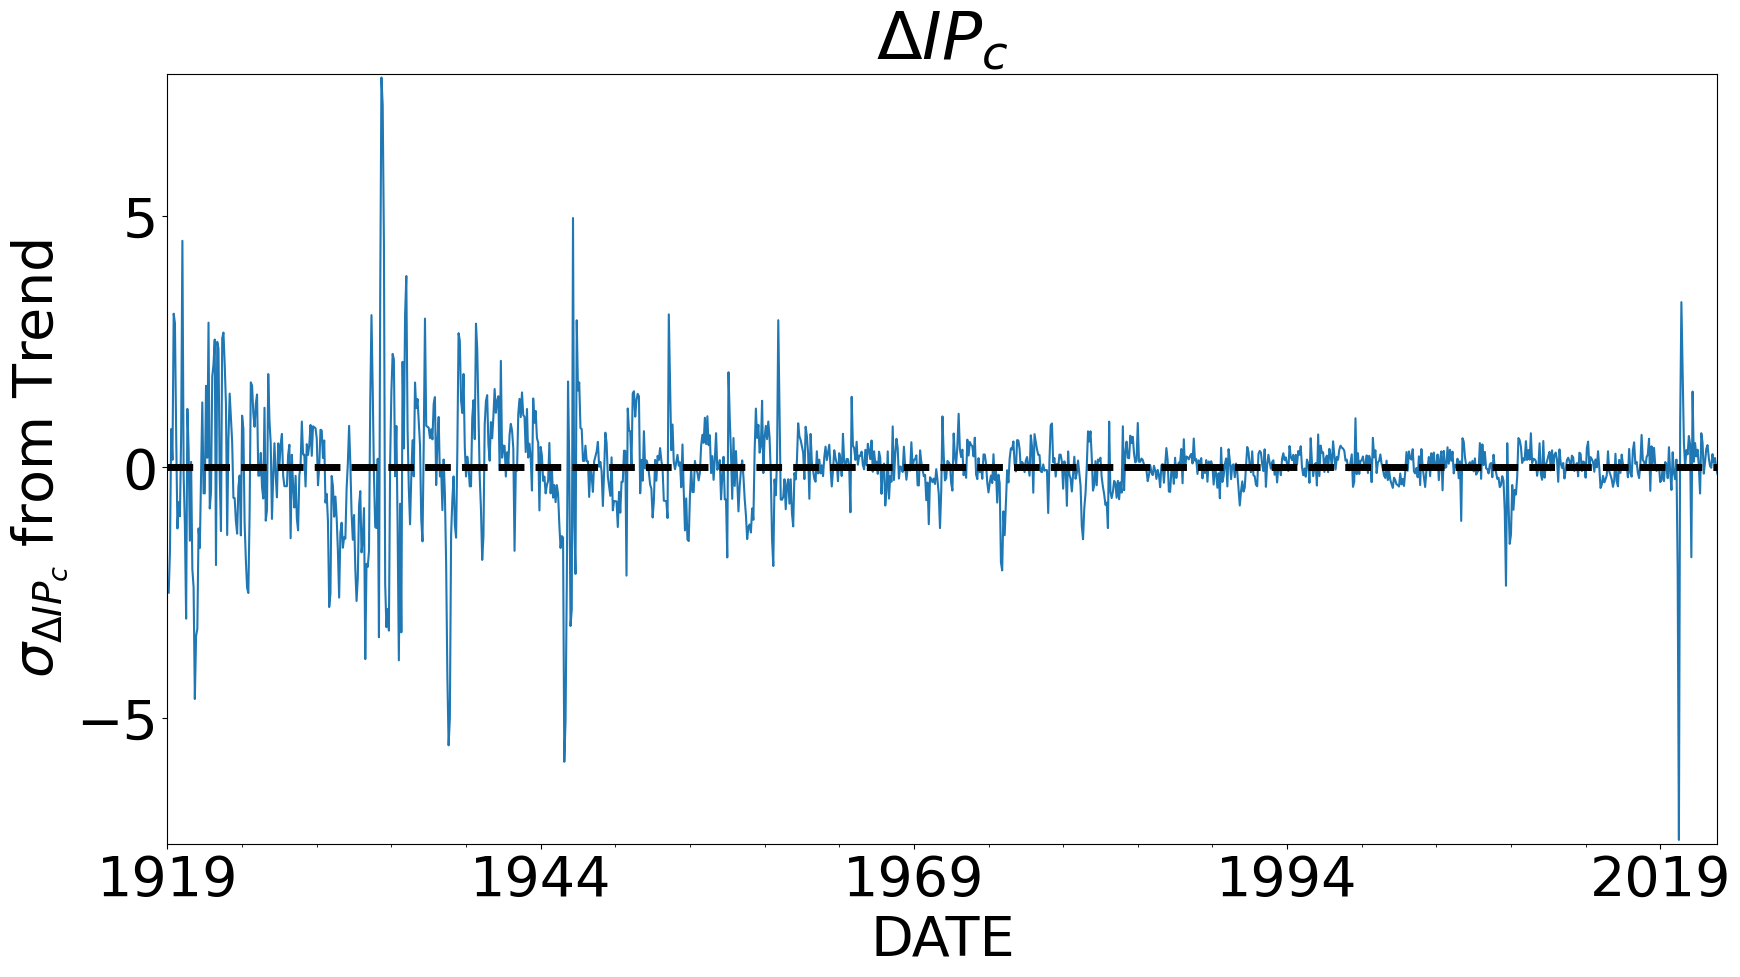

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
reg_sd_diff_data = (reg_diff_data/reg_diff_data.std())
reg_sd_diff_data.plot.line()
ax.axhline(reg_sd_diff_data.mean(), color = "k",ls = "--", linewidth = 5)
ax.set_title("$\\Delta IP_{c}$")
ax.set_ylabel("$\\sigma_{\\Delta IP_c}$ from Trend")
reg_sd_diff_data.describe()

<AxesSubplot:>

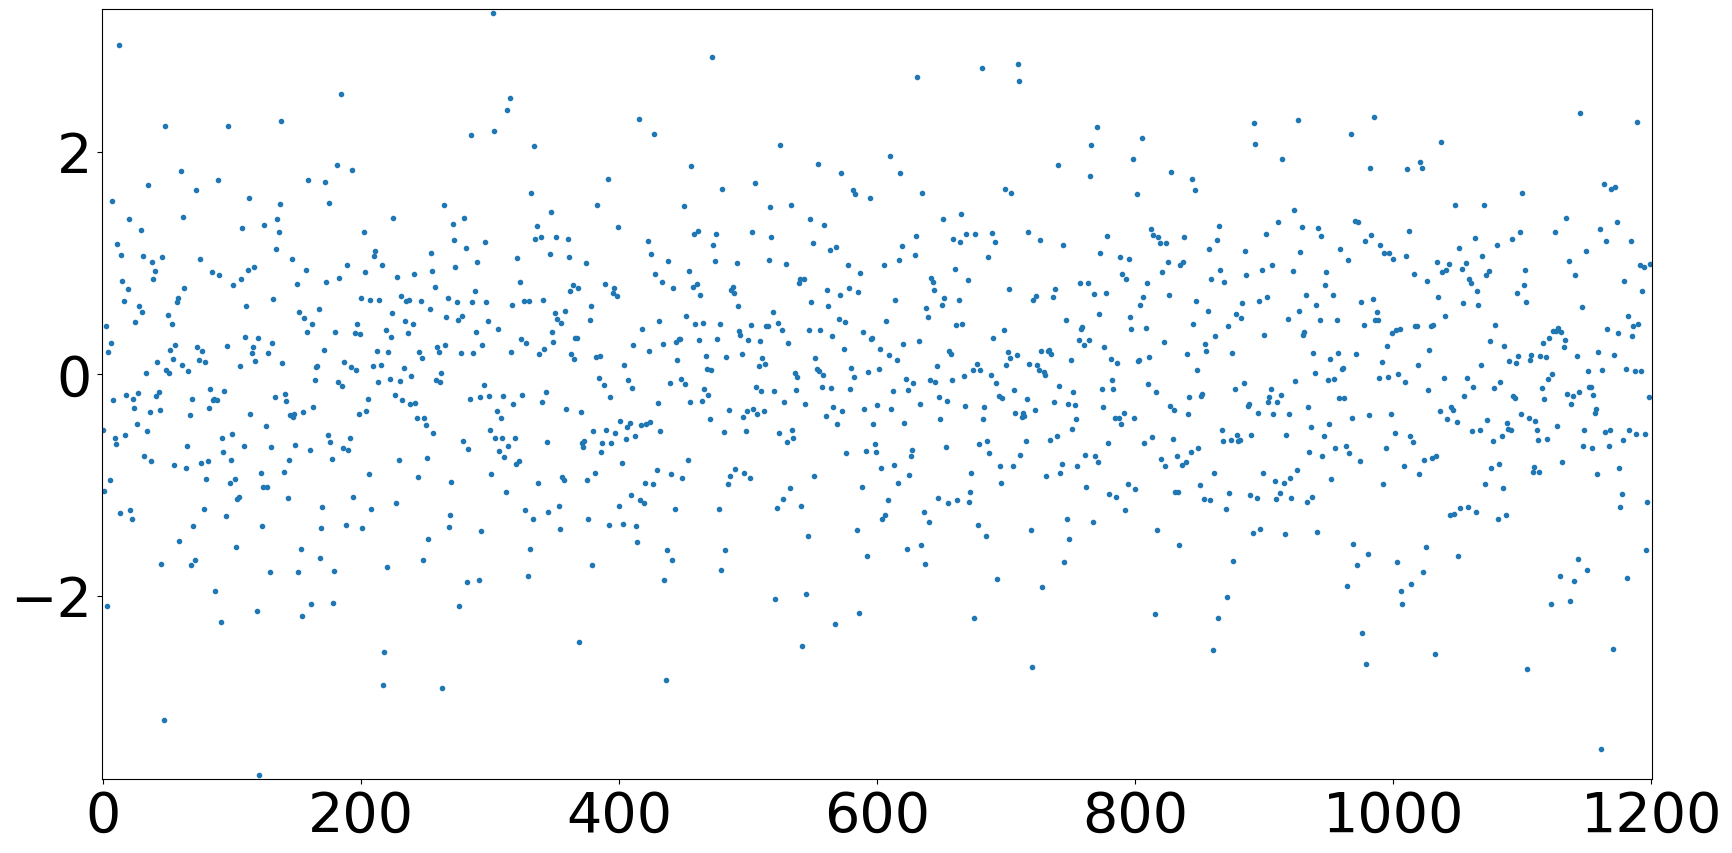

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,10))
pd.DataFrame([np.random.normal() for i in range(1200)]).plot.line(ax=ax, ls = "", marker = ".", legend = None)

Text(0.5, 0, 'Lag')

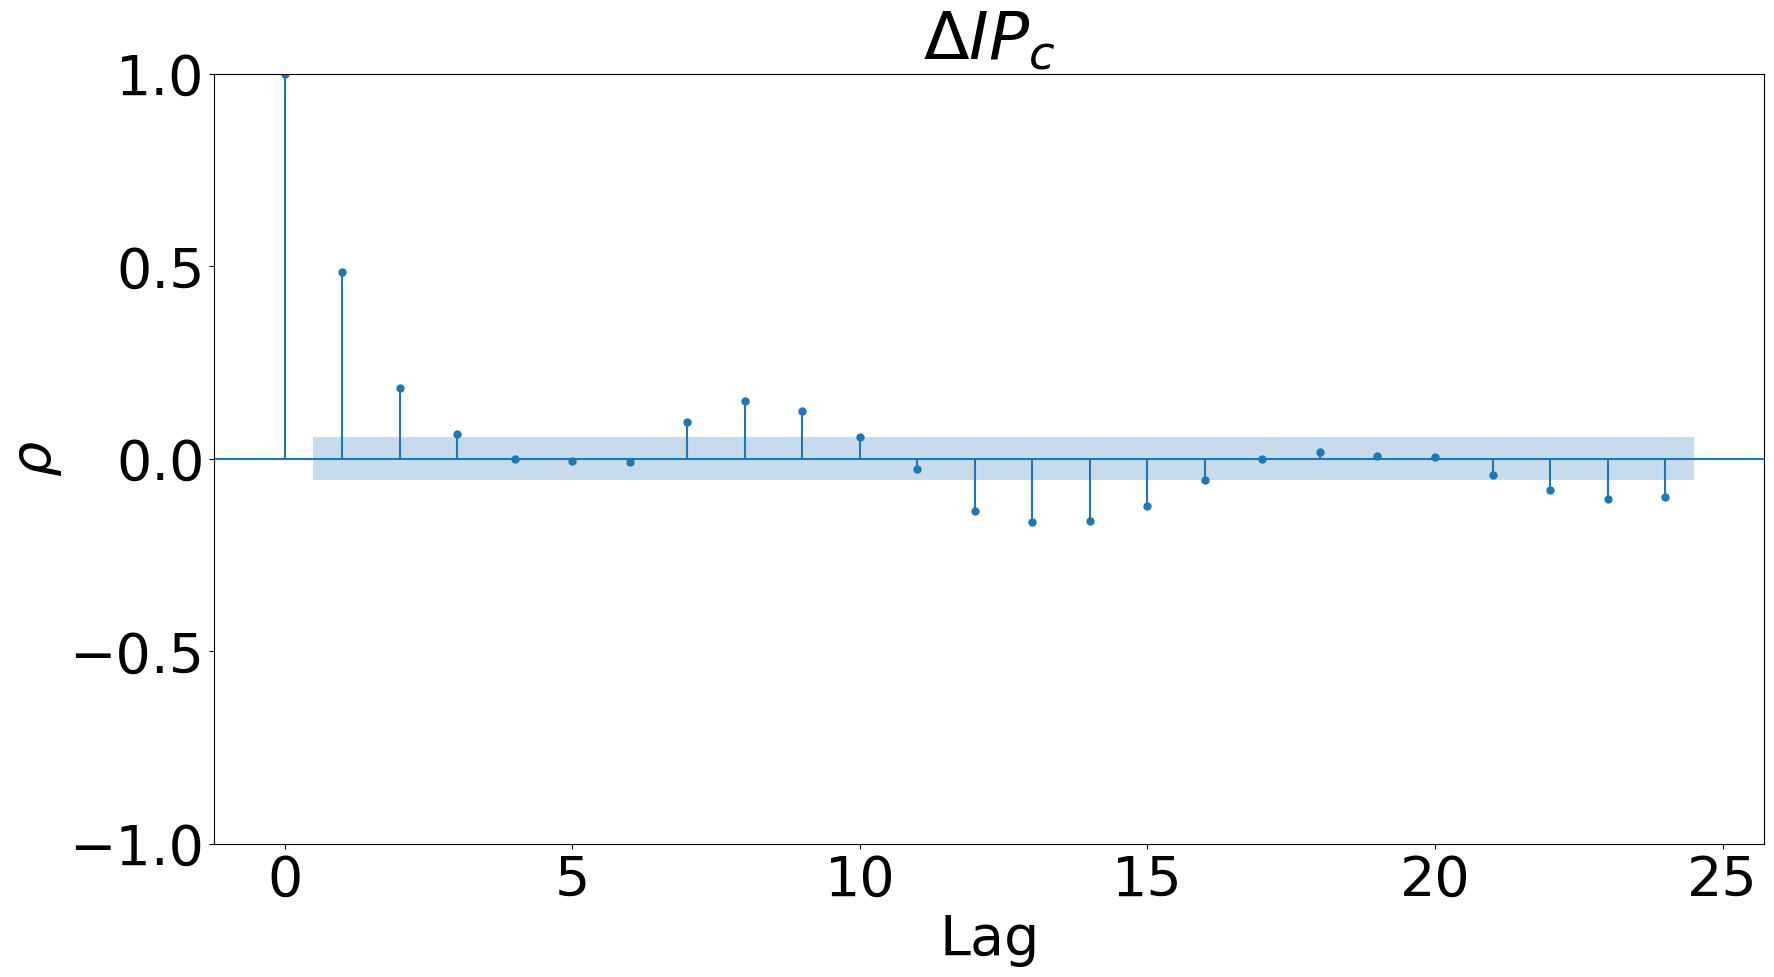

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize = (20,10))
plot_acf(reg_diff_data.dropna(),
         title = "$\\Delta IP_{c}$", 
         ax = ax, 
         lags = 24,
         bartlett_confint = False)
ax.set_ylabel("$\\rho$")
ax.set_xlabel("Lag")


Text(0.5, 1.0, '$0.88X^{0.62}$')

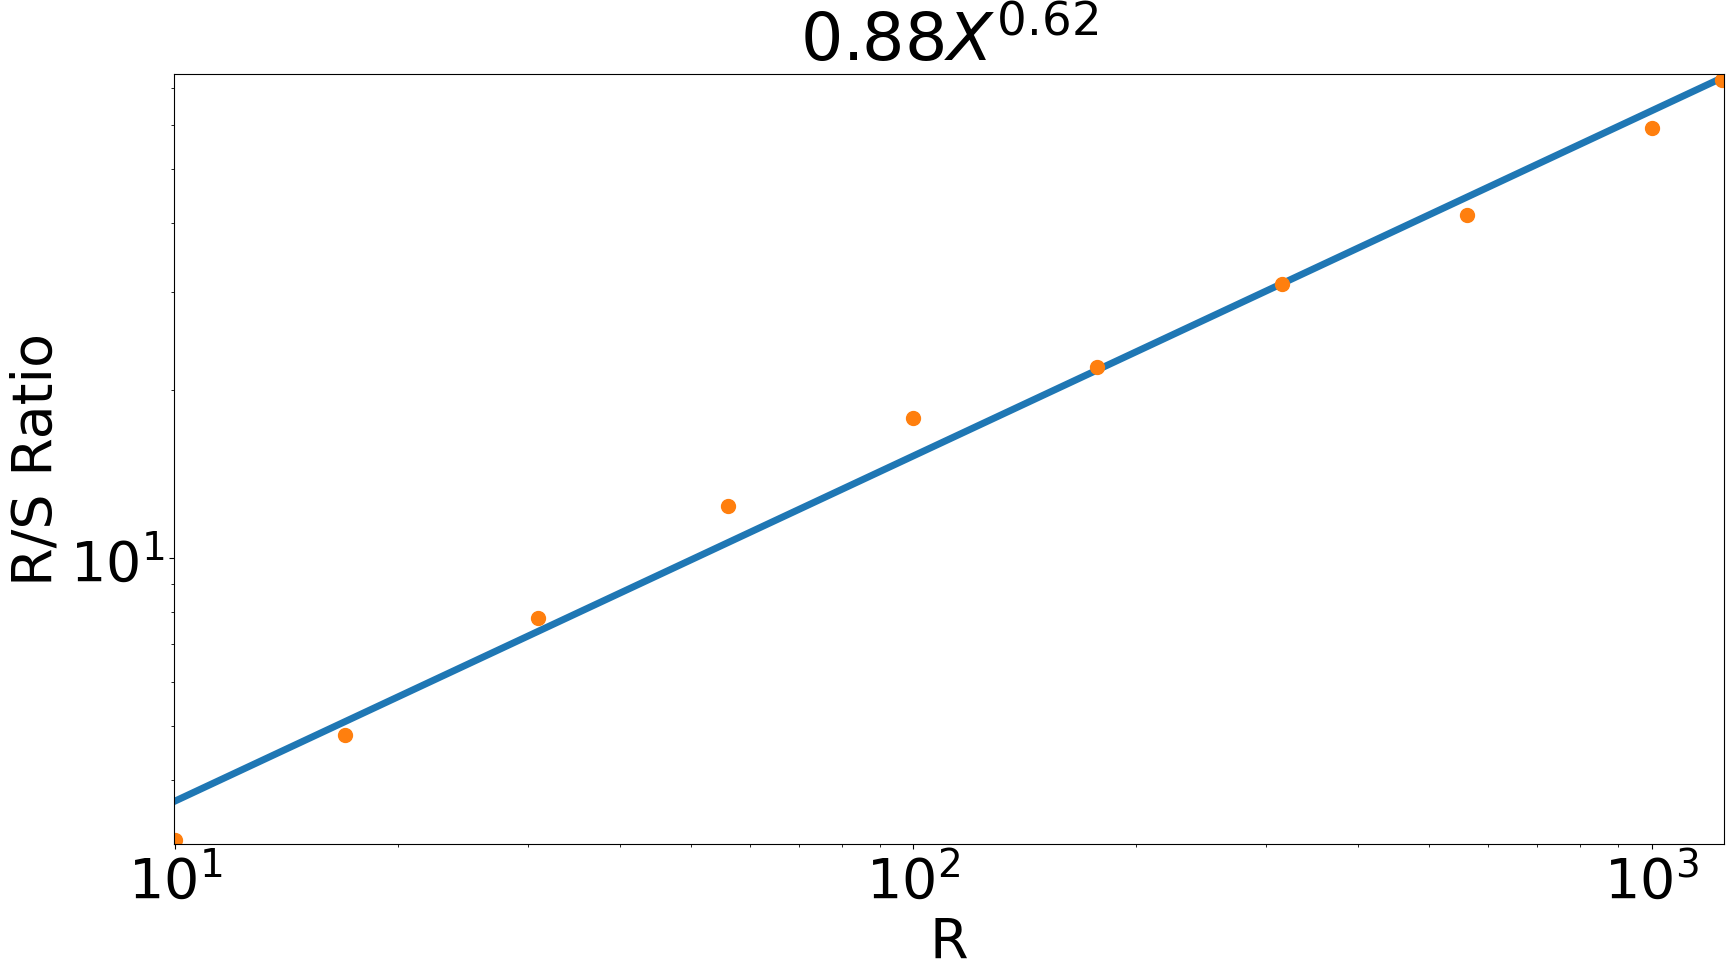

In [14]:
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(data_dict["Data"].pct_change().div(12).add(1).pow(12).dropna(),
                        kind='change', simplified=False)
# H, c, data = compute_Hc(reg_data["IP"].diff().dropna(), kind='random_walk', simplified=True)
H_df = pd.DataFrame([data[0], c*data[0]**H, data[1]], index = ["R", "Fitted", "R/S Ratio"]).T.set_index(["R"])
fig, ax = plt.subplots(figsize = (20,10))
H_df["Fitted"].plot.line(ls = "-", linewidth = 5, ax = ax)
H_df["R/S Ratio"].plot.line(ls = "", marker = ".", markersize = 20, ax = ax)
ax.set_ylabel("R/S Ratio")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("$" + str(round(c,2)) + "X^{" + str(round(H,2)) + "}$")
# ax.set_title("H = " + str(round(H,2)) + "\nC = " + str(round(c,2)))

Text(0.5, 1.0, '$1.15X^{0.35}$')

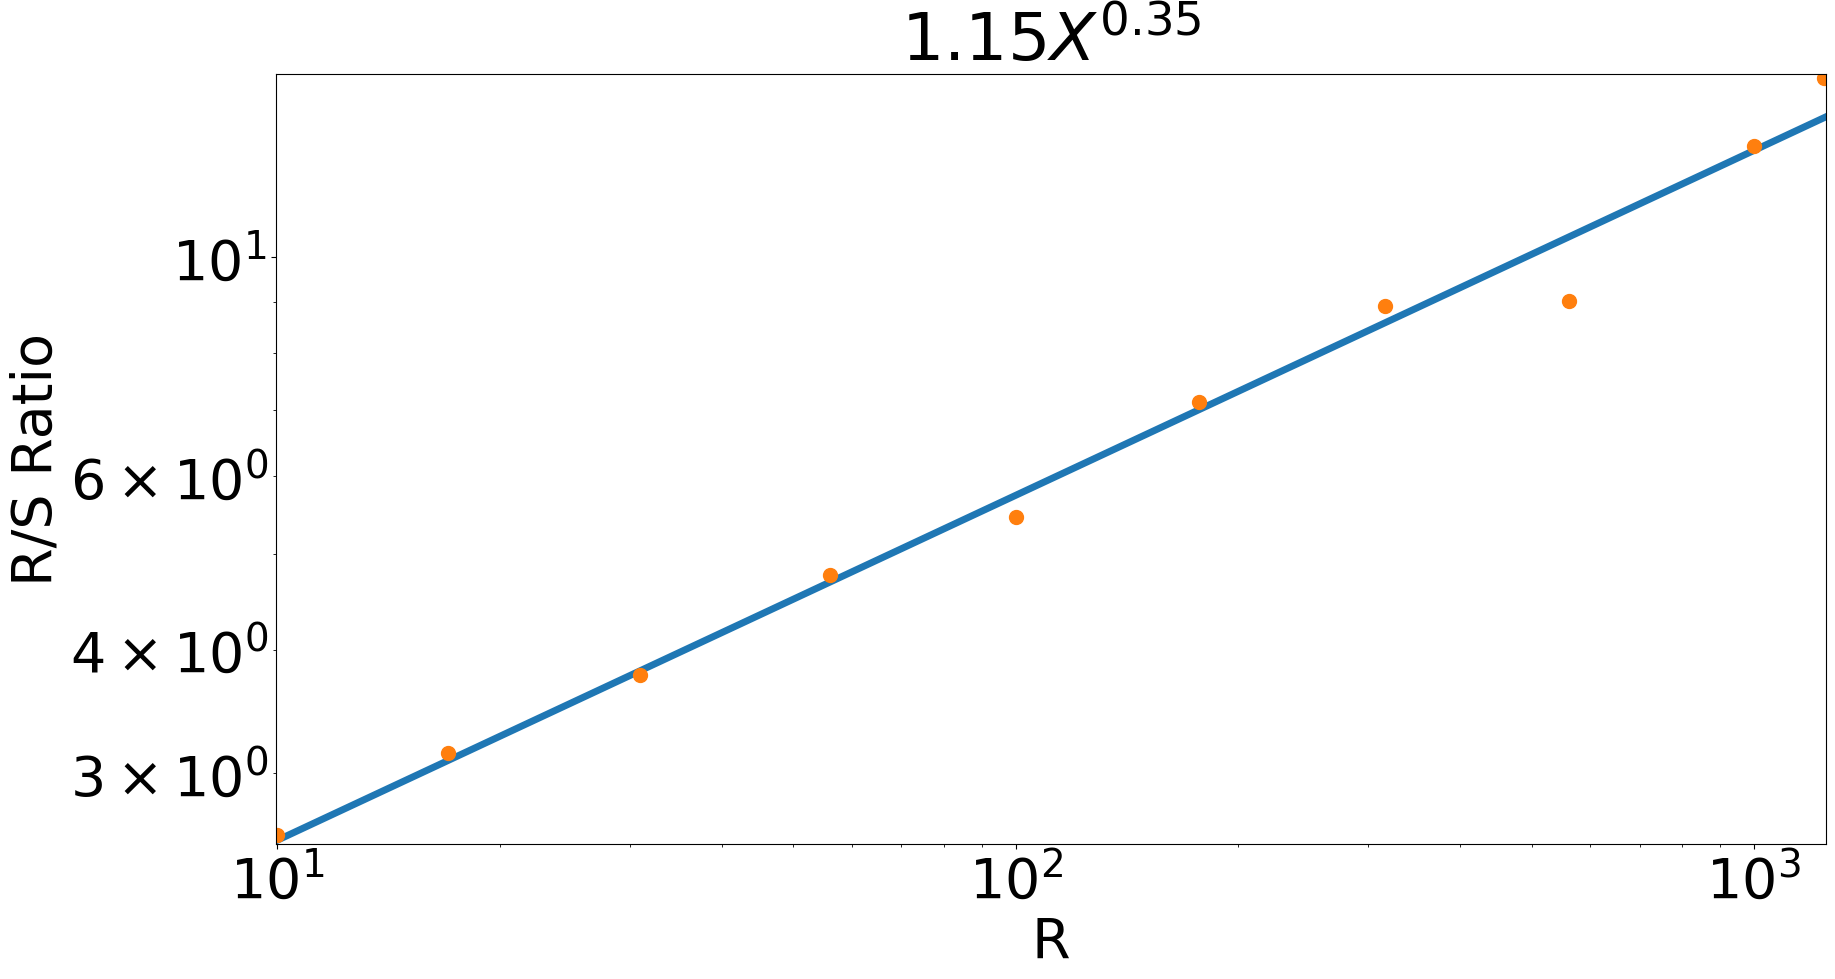

In [15]:
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(reg_data["IP"].diff().dropna(),
                        kind='random_walk', simplified=True)
# H, c, data = compute_Hc(reg_data["IP"].diff().dropna(), kind='random_walk', simplified=True)
H_df = pd.DataFrame([data[0], c*data[0]**H, data[1]], index = ["R", "Fitted", "R/S Ratio"]).T.set_index(["R"])
fig, ax = plt.subplots(figsize = (20,10))
H_df["Fitted"].plot.line(ls = "-", linewidth = 5, ax = ax)
H_df["R/S Ratio"].plot.line(ls = "", marker = ".", markersize = 20, ax = ax)
ax.set_ylabel("R/S Ratio")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("$" + str(round(c,2)) + "X^{" + str(round(H,2)) + "}$")
# ax.set_title("H = " + str(round(H,2)) + "\nC = " + str(round(c,2)))

Text(0.5, 1.0, '$0.93X^{0.59}$')

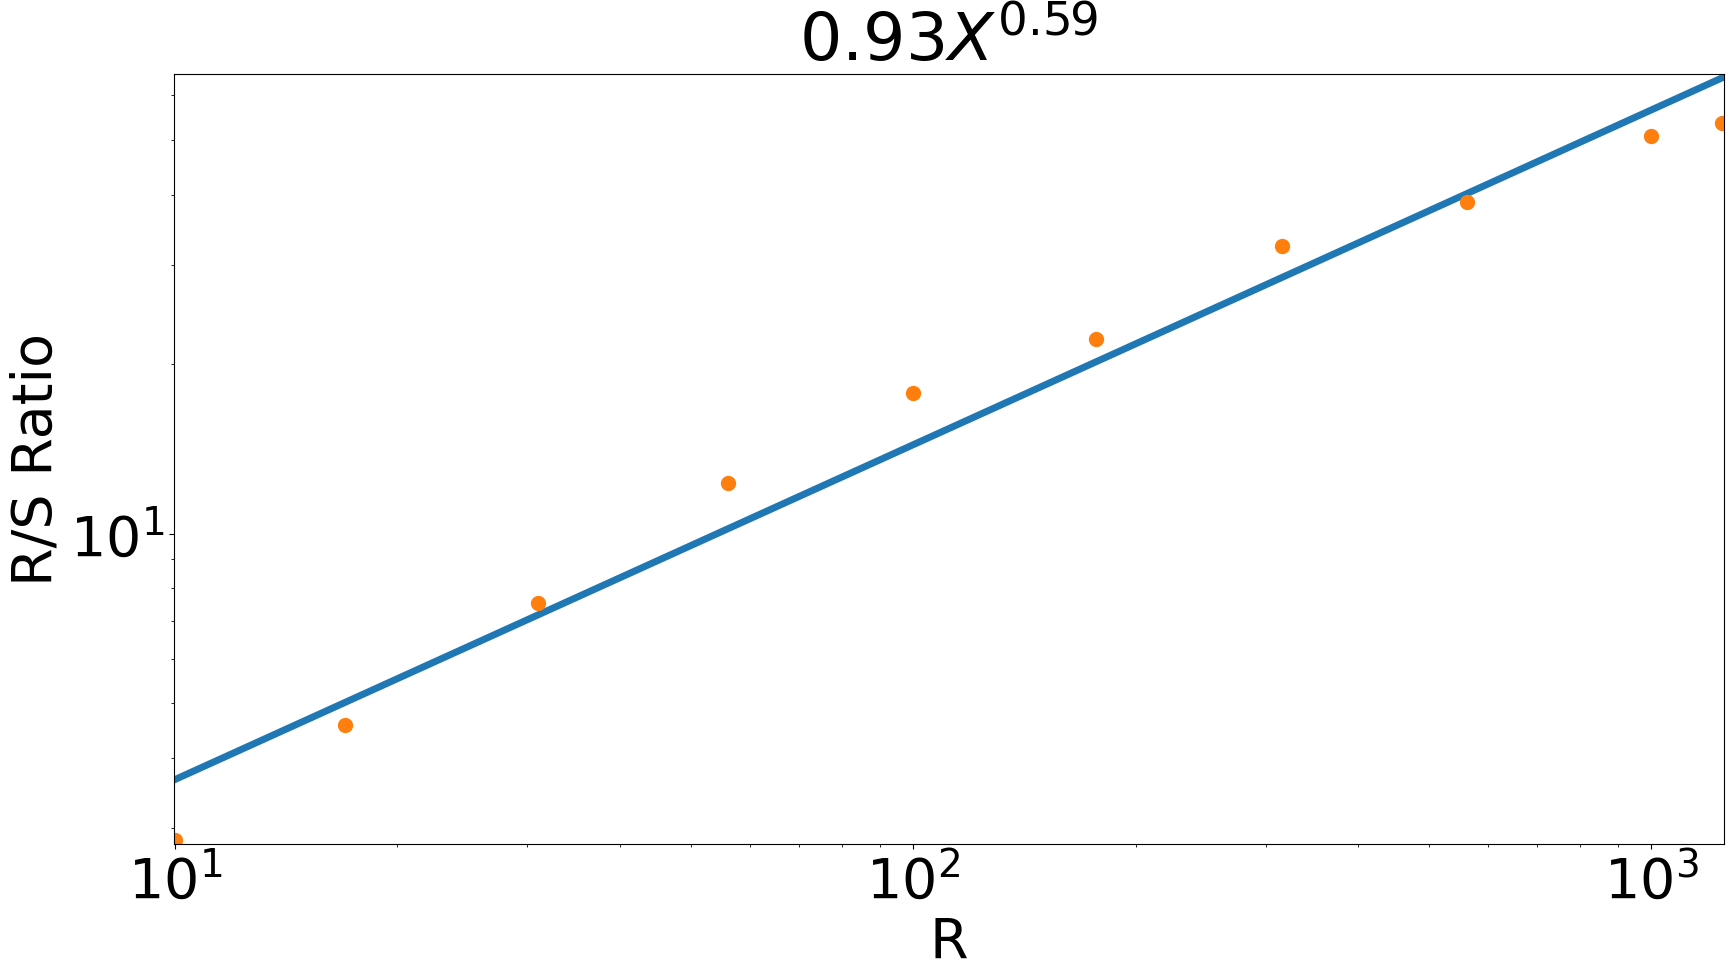

In [16]:
from hurst import compute_Hc, random_walk
# H, c, data = compute_Hc(data_dict["Data"].pct_change().div(12).add(1).pow(12).dropna(), kind='change', simplified=True)
H, c, data = compute_Hc(reg_data["$IP_{ct}$"].dropna(), kind='random_walk', simplified=False)
H_df = pd.DataFrame([data[0], c*data[0]**H, data[1]], index = ["R", "Fitted", "R/S Ratio"]).T.set_index(["R"])
fig, ax = plt.subplots(figsize = (20,10))
H_df["Fitted"].plot.line(ls = "-", linewidth = 5, ax = ax)
H_df["R/S Ratio"].plot.line(ls = "", marker = ".", markersize = 20, ax = ax)
ax.set_ylabel("R/S Ratio")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("$" + str(round(c,2)) + "X^{" + str(round(H,2)) + "}$")


In [17]:
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

results = []
for i in range(1000):
    data = stats.norm.rvs(0,1,100000)
    x = np.linspace(min(data),max(data),100000)
    mu, var = stats.norm.fit(data)
    std = var ** .5
    p = stats.norm.pdf(x, mu,std)
    p_at_x = stats.norm.pdf(7,mu,std)
    results.append(p_at_x)


<AxesSubplot:title={'center':'9e-12'}, ylabel='Frequency'>

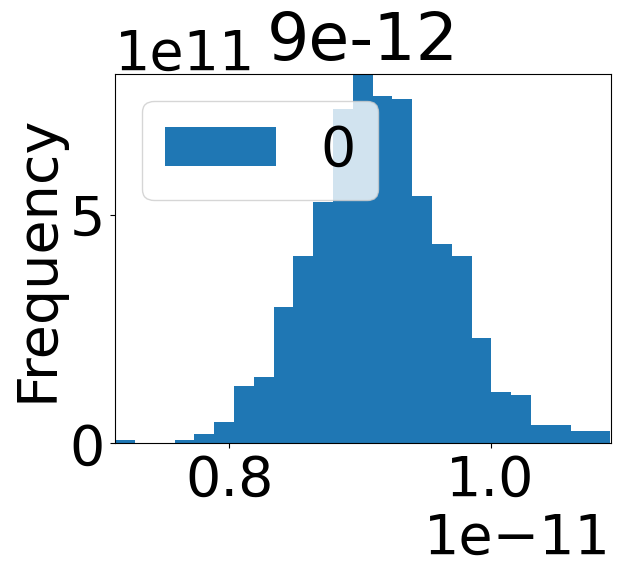

In [18]:
pd.DataFrame(results).plot.hist(density = True, bins = 25, title = str(round(sum(results)/len(results),12)))


In [19]:
data_dict["Data"]["IP"].to_csv("INDPRO.csv")
data_dict["Log"]["IP"].to_csv("LogINDPRO.csv")
data_dict["Log"]["IP"].diff().dropna().to_csv("LogDiffINDPRO.csv")

In [20]:
reg_df = reg_data[["$IP_{ct}$"]]
reg_df["$IP_{ct-1}$"] =  reg_data["$IP_{ct}$"].shift()
reg_df["constant"] = 1
reg_df.dropna(inplace=True)
y = reg_df[["$IP_{ct}$"]]
X = reg_df[["$IP_{ct-1}$", "constant"]]
X["constant"] = 1
reg = sm.OLS(y,X)
results = reg.fit()
print(results.summary())
# estimate long-run trend
pred = results.predict(X)
res = pd.DataFrame(results.resid, columns =["Res"])
res["ResLag"] = res["Res"].shift()
res.dropna(inplace = True)
y = res[["Res"]]
X = res[["ResLag"]]
res_reg = sm.OLS(y,X).fit()
res_reg.summary()

                            OLS Regression Results                            
Dep. Variable:              $IP_{ct}$   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 6.547e+04
Date:                Thu, 04 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:31:10   Log-Likelihood:                 3155.6
No. Observations:                1246   AIC:                            -6307.
Df Residuals:                    1244   BIC:                            -6297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
$IP_{ct-1}$     0.9902      0.004    255.876      

C:\Users\JLCat\AppData\Local\Temp\ipykernel_11500\555245988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df["$IP_{ct-1}$"] =  reg_data["$IP_{ct}$"].shift()
C:\Users\JLCat\AppData\Local\Temp\ipykernel_11500\555245988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df["constant"] = 1
C:\Users\JLCat\AppData\Local\Temp\ipykernel_11500\555245988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Res   R-squared (uncentered):                   0.238
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              389.1
Date:                Thu, 04 Jan 2024   Prob (F-statistic):                    1.39e-75
Time:                        14:31:10   Log-Likelihood:                          3325.0
No. Observations:                1245   AIC:                                     -6648.
Df Residuals:                    1244   BIC:                                     -6643.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ResLag         0.4870      0.025     19.727      0.000       0.439       0.535
==============================================================================
Omnibus:                      273.951   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7735.585
Skew:                           0.309   Prob(JB):                         0.00
Kurtosis:                      15.196   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""